# Initializations

## Inits

In [5]:
#################################
######### COLAB NOTEBOOK ########
#################################

In [6]:
from google.colab import drive
drive.mount("drive", force_remount=True)

Mounted at drive


In [7]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install dendropy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
libgif-dev is already the newest version (5.1.4-2ubuntu0.1).
libgif-dev set to manually installed.
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libpixman-1-dev libxcb-shm0-dev
0 upgraded, 4 newly installed, 0 to remove and 39 not upgraded.
Need to get 930 kB of archives.
After this operation, 3,986 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcairo-script-interpreter2 amd64 1.15.10-2ubuntu0.1 [53.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpixman-1-dev amd64 0.34.0-2 [244 kB]
Get:3 http://archive.ubuntu.com/ubuntu bio

In [8]:
import graph_tool.all as gt
import networkx as nx
import graphviz
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import numpy as np
import dendropy
from dendropy.calculate import treecompare
import warnings
import pandas as pd
import torch
warnings.filterwarnings('ignore')

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:1501: RuntimeWarning: Error importing Gtk module: cannot import name '_gi' from 'gi' (/usr/lib/python3/dist-packages/gi/__init__.py); GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [9]:
#################################
#### FUNCTION THAT CONVERTS #####
#### GRAPH_TOOLS GRAPH TO  ######
########### NETWORKX ############
#################################


def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once

    for node, data in list(nxG.nodes(data=True)):
        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in list(nxG.edges(data=True)):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
          if isinstance(val, float):
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in list(nxG.nodes(data=True)):
        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties


    # Add the edges
    for src, dst, data in list(nxG.edges(data=True)):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
          if isinstance(value, float):
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

## Read Graph

In [ ]:
x = 9
G = nx.read_graphml('drive/My Drive/thesis_masters/graphMLs/CB/CB' + str(x) + '.graphml')

In [ ]:

for x in G.edges.data('weight'):
    G.get_edge_data(x[0],x[1])['weight'] = float(x[2])

In [ ]:
G = G.to_undirected()
nxG = G
gtG = nx2gt(nxG)
gtG.list_properties()

In [ ]:
output_mapping = ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train', 'lawn_mower', 'rocket', 'streetcar', 'tank', \
                  'tractor', 'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'bear', 'leopard', 'lion', 'tiger', 'wolf']

def create_graph_list(K, elements, level):
  for x in range(len(level)):
    K.add_node(len(level) - 1 - x, elements = elements[len(level) - 1 - x], level = level[len(level) - 1 - x])

  for x in list(nx.get_node_attributes(K,'elements').items()):
    for y in list(nx.get_node_attributes(K,'elements').items()):
      if x[1] != y[1]:
        if set(x[1]) <=set(y[1]):
          K.add_edge(x[0],y[0])
          break

original = nx.DiGraph()
elements= [list(output_mapping), \
                          list(output_mapping)[:10], list(output_mapping)[10:20], \
                          ['bus', 'bicycle',  'motorcycle', 'pickup_truck', 'train', 'streetcar'], ['lawn_mower', 'rocket', 'tank', 'tractor'], ['porcupine','possum','raccoon','skunk'], ['bear', 'leopard', 'lion', 'tiger', 'wolf','fox'],\
                          ['pickup_truck'], ['train', 'streetcar'],['bus'], ['motorcycle','bicycle'],['lawn_mower'], ['tractor'],['rocket'],['tank'],['porcupine'], ['possum'], ['raccoon'], ['skunk'],['bear'], ['leopard', 'lion', 'tiger'],['wolf', 'fox'],\
                          ['motorcycle'], ['bicycle'], ['train'], ['streetcar'], ['wolf'], ['fox'], ['leopard'], ['lion'],['tiger']]
level = [0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4]
create_graph_list(original, elements, level)

output_mapping = sorted(output_mapping)

# Nested Stochastic Block Model




## Hierarchy Trees


In [ ]:
state = gt.minimize_nested_blockmodel_dl(gtG, state_args=dict(recs=[gtG.ep.weight], rec_types=["real-exponential"]))
#state = gt.minimize_nested_blockmodel_dl(gtG, B_min=len(G.nodes))

state.print_summary()
levels = state.get_levels()

l: 0, N: 193, B: 8
l: 1, N: 8, B: 3
l: 2, N: 3, B: 2
l: 3, N: 2, B: 1


In [ ]:
##################################################
### REMOVE HIERARCHY LEVELS THAT DO NOT ##########
## INFLUENCE THE GROUPINGS OF OUTPUT CLASSES #####
##################################################

hierarchies = []

for x in range(len(levels)):
  if x == 0:
    hierarchies.append(np.array(list(levels[0].get_blocks()))[list(pd.Series(gtG.vp['classId'])[pd.Series(gtG.vp['classId']) != ''].apply(int).sort_values(ascending=True).index)])  
  else:
    temp = []
    for y in hierarchies[x-1]:
      temp.append(levels[x].get_blocks()[y])
    hierarchies.append(temp)

index_delete = []
for i, x in enumerate(hierarchies):
  if i > 0:
    if len(set(x)) == len(set(hierarchies[i - 1])):
      index_delete.append(i)
      
for i in reversed(index_delete):
  del hierarchies[i]


####################################################################
####### LIST OF LISTS HIERARCHY CONVERTED TO DICTIONARY  ###########
######  UPDATED - (KEY = NODE INDEX; VALUE = OUTPUT_CLASSES) #######
####################################################################

max_nodes = 0
for x in hierarchies:
  max_nodes += len(set(x))

for x in hierarchies:
  temp = set(x)
  
  indices = []
  for y in temp:
    indices.append(list(pd.Series(x)[pd.Series(x) == y].index))

  for y in indices:
    for z in y:
      x[z] = max_nodes
    max_nodes -= 1

updated = []
for y in range(len(hierarchies)):
  layer = dict()
  for i, x in enumerate(hierarchies[y]):
    if x not in layer.keys():
      layer[x] = [output_mapping[i]]
    else:
      layer[x].append(output_mapping[i])
  updated.append(layer)

In [ ]:
######################################
####### CREATE HIERARCHY GRAPH #######
######################################

g=nx.DiGraph()
for x in updated:
  for y in x.keys():
    g.add_node(y, elements = x[y])

nodes = dict()

for i, x in nx.get_node_attributes(g, 'elements').items():
  if x not in list(nodes.values()):
    nodes[i] = x

g=nx.DiGraph()
for x, y in nodes.items():
  g.add_node(x, elements = y)

for x in list(nx.get_node_attributes(g,'elements').items()):
  for y in list(nx.get_node_attributes(g,'elements').items()):
    if x[1] == y[1]:
      if list(nx.get_node_attributes(g,'elements').values()).count(x[1]) >= 2:
        g.add_edge(x[0],y[0])
    else:
      if set(x[1]) <=set(y[1]):
        g.add_edge(x[0],y[0])
        break

#########################################
##### Expand graph so that leaf nodes ### 
##### are composed of only of 1 class ###
#########################################

temp = list(g.nodes)
for x in temp:
  if (g.in_degree(x) == 0) & (len(g.nodes[x]['elements']) > 1):

    for y in g.nodes[x]['elements']:
      g.add_node(max(g.nodes)+1, elements = [y])
      g.add_edge(max(g.nodes), x)  

###### PLOTTING ######
def special_plotting(G):
  nx.nx_agraph.write_dot(G,'test.dot')
  plt.figure(figsize=(30,6))
  pos=graphviz_layout(G, prog='dot')
  labels = nx.get_node_attributes(G, 'size') 
  nx.draw(G, pos,labels=labels, node_size = 2000, node_color = 'yellow')
  node_labels = nx.get_node_attributes(G,'elements')
  _ = nx.draw_networkx_labels(G, pos, labels = node_labels, font_size = 11)

def create_graph_list(K, elements, level):
  for x in range(len(level)):
    K.add_node(len(level) - 1 - x, elements = elements[len(level) - 1 - x], level = level[len(level) - 1 - x])

  for x in list(nx.get_node_attributes(K,'elements').items()):
    for y in list(nx.get_node_attributes(K,'elements').items()):
      if x[1] != y[1]:
        if set(x[1]) <=set(y[1]):
          K.add_edge(x[0],y[0])
          break

In [ ]:
import matplotlib.pyplot as plt


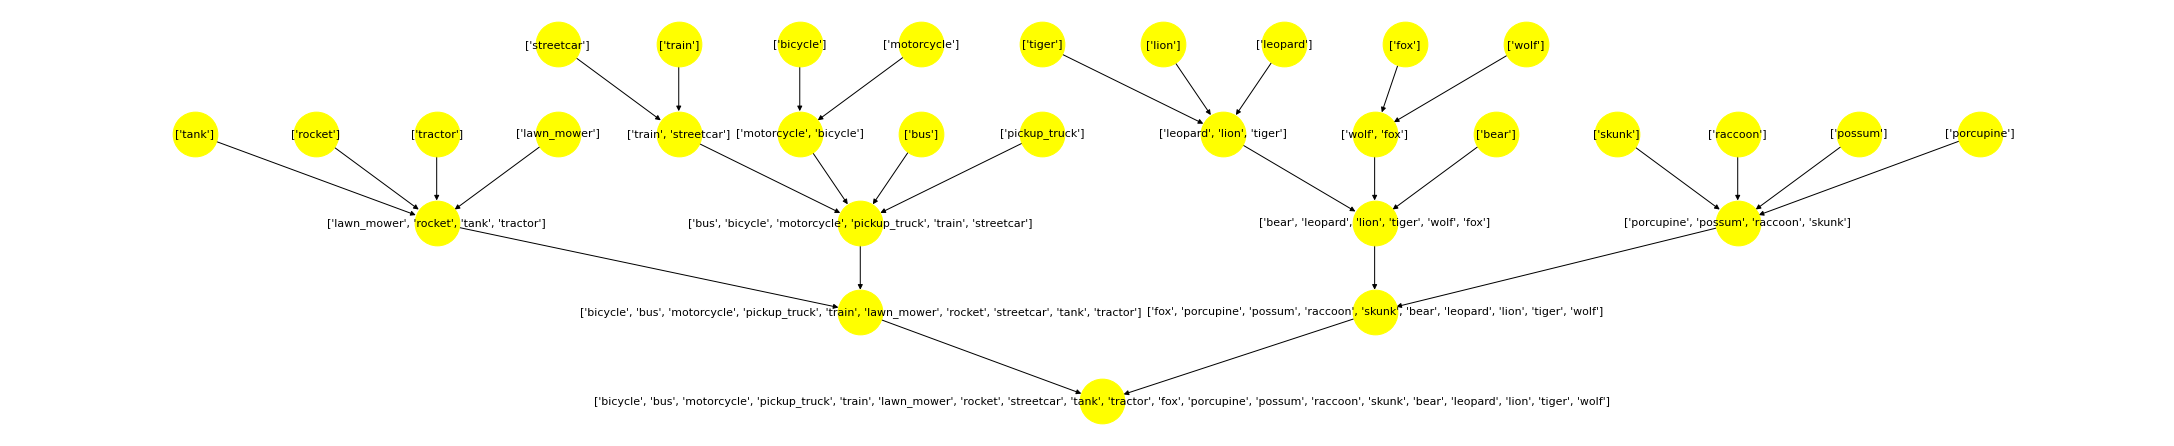

In [ ]:
############################################################################
##### HIERARCHY GRAPH OF PREDEFINED HIERARCHICAL STRUCTURE OF THE DATA #####
############################################################################
def special_plotting(G):
  nx.nx_agraph.write_dot(G,'test.dot')
  plt.figure(figsize=(30,6))
  pos=graphviz_layout(G, prog='dot')
  labels = nx.get_node_attributes(G, 'size') 
  nx.draw(G, pos,labels=labels, node_size = 2000, node_color = 'yellow')
  node_labels = nx.get_node_attributes(G,'elements')
  _ = nx.draw_networkx_labels(G, pos, labels = node_labels, font_size = 11)
  
def create_graph_list(K, elements, level):
  for x in range(len(level)):
    K.add_node(len(level) - 1 - x, elements = elements[len(level) - 1 - x], level = level[len(level) - 1 - x])

  for x in list(nx.get_node_attributes(K,'elements').items()):
    for y in list(nx.get_node_attributes(K,'elements').items()):
      if x[1] != y[1]:
        if set(x[1]) <=set(y[1]):
          K.add_edge(x[0],y[0])
          break

original = nx.DiGraph()
elements= [list(output_mapping), \
                          list(output_mapping)[:10], list(output_mapping)[10:20], \
                          ['bus', 'bicycle',  'motorcycle', 'pickup_truck', 'train', 'streetcar'], ['lawn_mower', 'rocket', 'tank', 'tractor'], ['porcupine','possum','raccoon','skunk'], ['bear', 'leopard', 'lion', 'tiger', 'wolf','fox'],\
                          ['pickup_truck'], ['train', 'streetcar'],['bus'], ['motorcycle','bicycle'],['lawn_mower'], ['tractor'],['rocket'],['tank'],['porcupine'], ['possum'], ['raccoon'], ['skunk'],['bear'], ['leopard', 'lion', 'tiger'],['wolf', 'fox'],\
                          ['motorcycle'], ['bicycle'], ['train'], ['streetcar'], ['wolf'], ['fox'], ['leopard'], ['lion'],['tiger']]
level = [0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4]
create_graph_list(original, elements, level)


T = nx.DiGraph()
elements= [list(output_mapping), 
                          ['T-shirt/Top', 'Pullover',  'Ankle Boot', 'Sandal', 'Dress', 'Trouser'], ['Coat', 'Shirt', 'Sneaker', 'Bag'],\
                           ['T-shirt/Top', 'Pullover', 'Ankle Boot', 'Sandal' ], ['Dress', 'Trouser'], ['Sneaker', 'Coat', 'Shirt'],['Bag'], \
                            ['T-shirt/Top'], ['Shirt'], ['Sneaker'],['Ankle Boot'], ['Pullover'],['Coat'],['Sandal'], ['Dress'], ['Trouser']]
level = [0,1,1,2,2,2,2,3,3,3,3,3,3,3,3,3]
create_graph_list(T, elements, level)

L = nx.DiGraph()
elements= [list(output_mapping), 
                            ['T-shirt/Top', 'Pullover',  'Shirt'], ['Sandal', 'Sneaker', 'Ankle Boot'], ['Dress', 'Trouser', 'Bag'], ['Coat'],\
                            ['T-shirt/Top'], ['Shirt'], ['Sneaker'],['Ankle Boot'], ['Pullover'],['Sandal'], ['Dress', 'Trouser'], ['Bag'],\
                            ['Dress'], ['Trouser']]
level = [0,1,1,1,1,2,2,2,2,2,2,2,2,3,3]
create_graph_list(L, elements, level)

special_plotting(original)



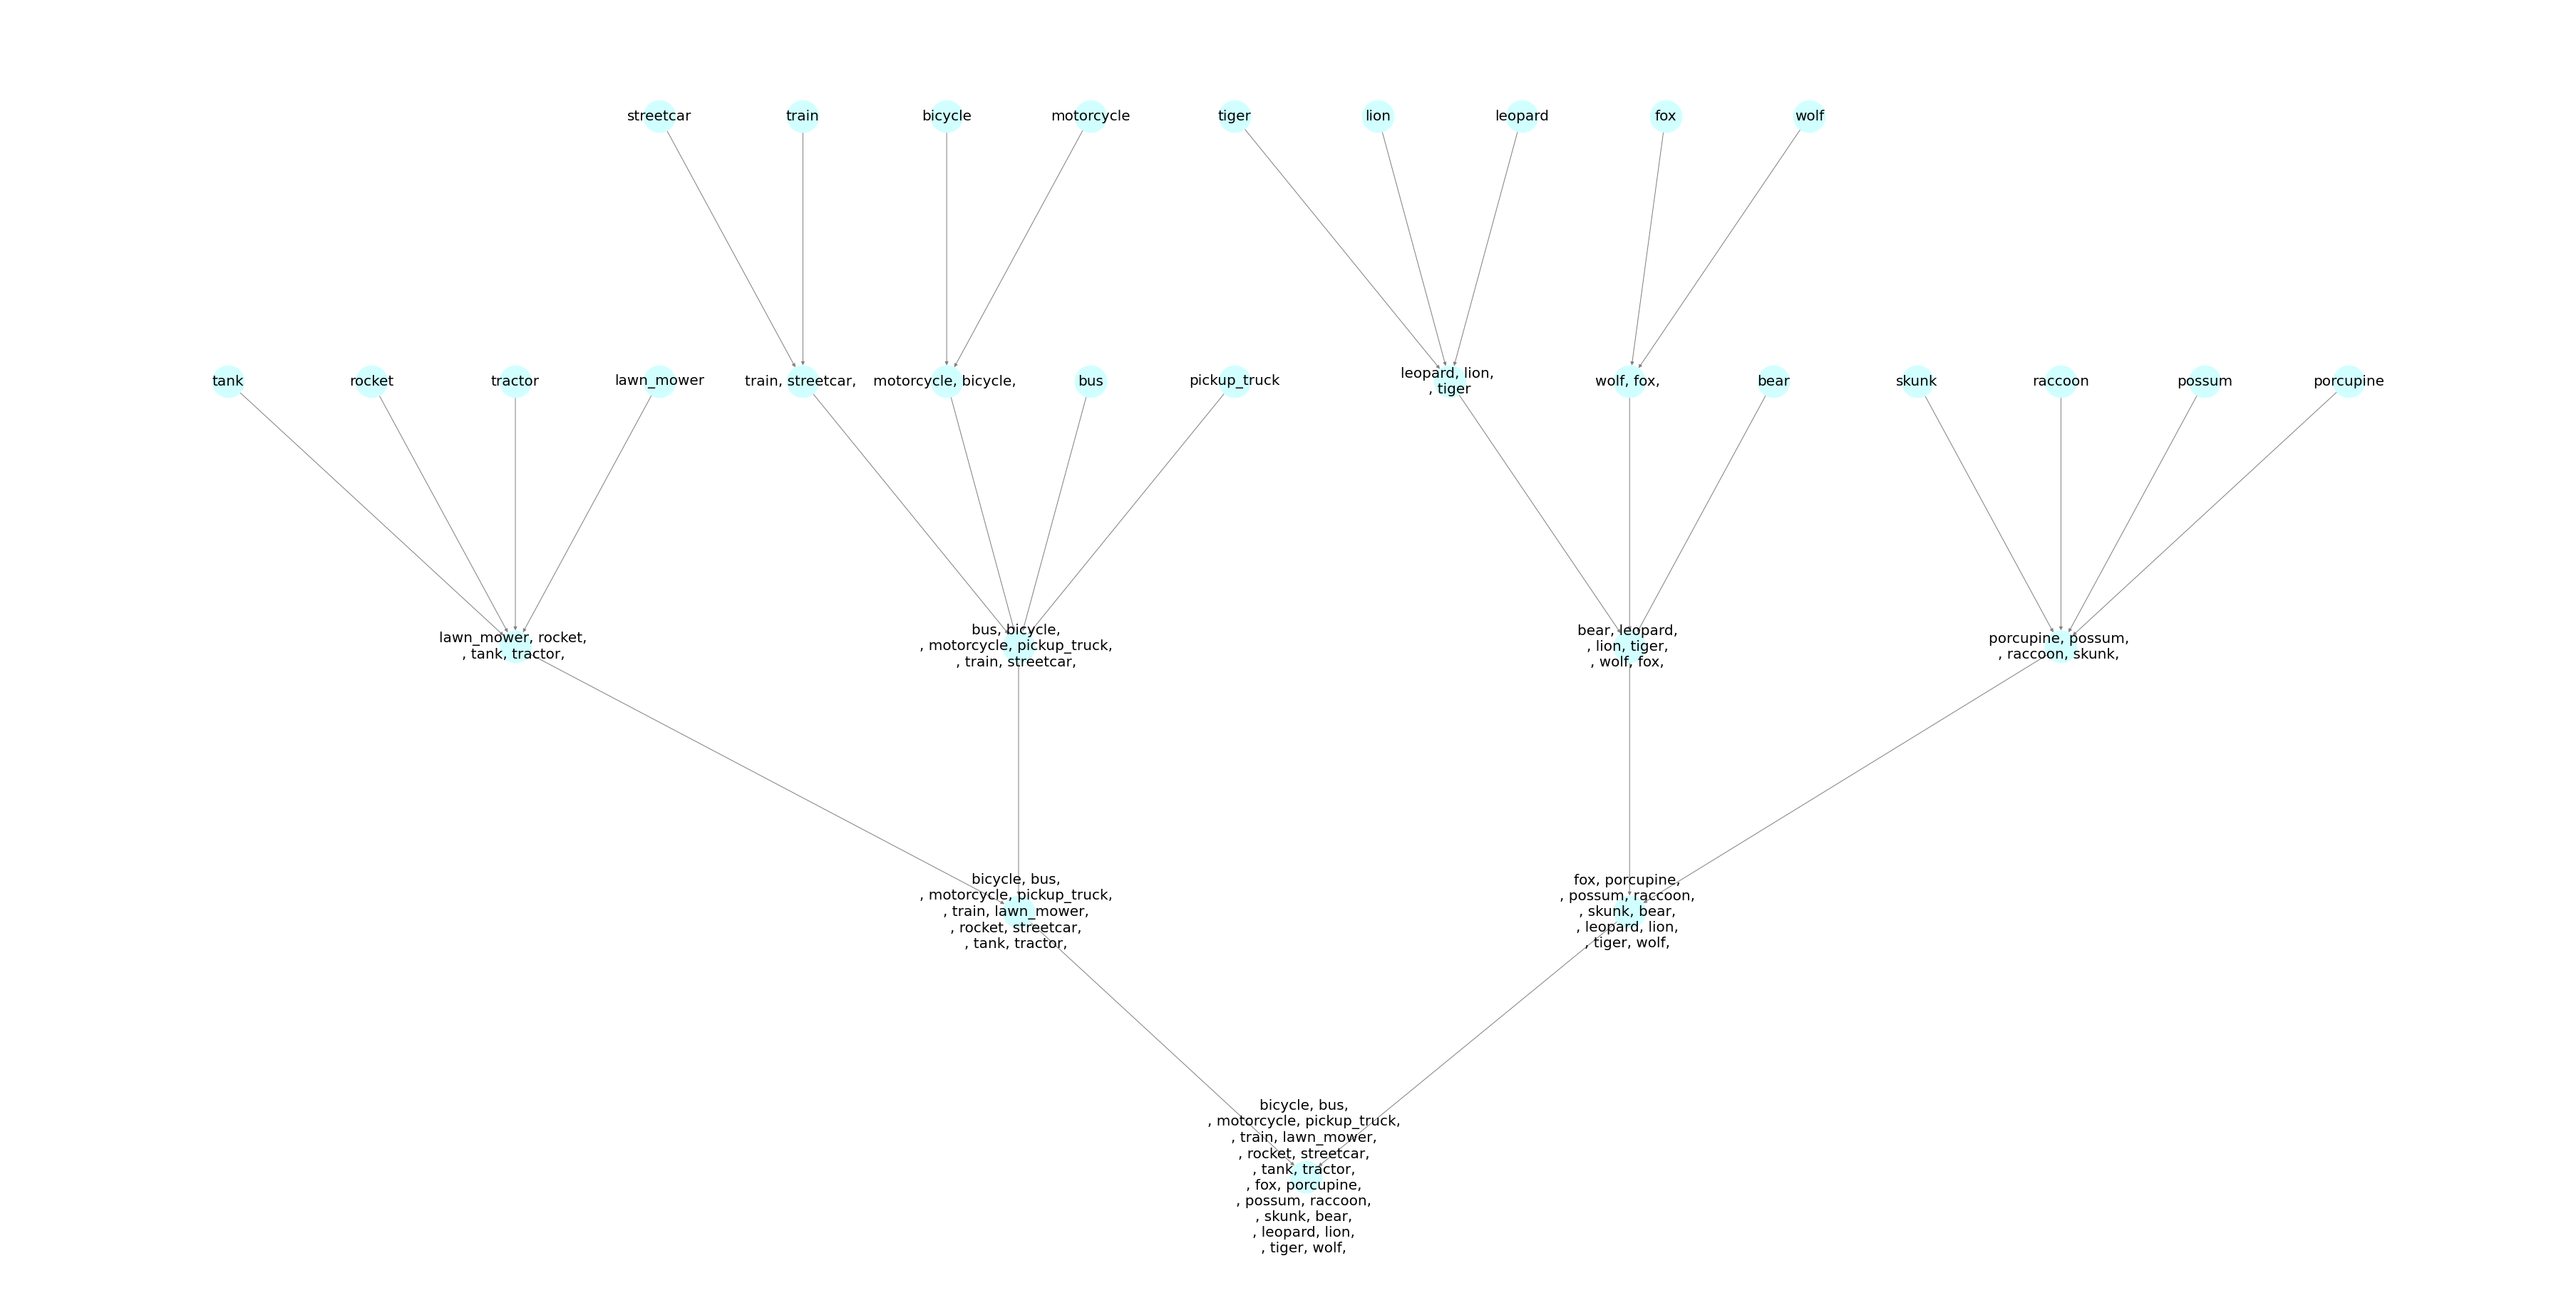

In [ ]:
def special_plotting(G, plot_size = None, font_size = None, per_row = None):
  if plot_size is None:
    plt.figure(figsize=(25,11))
  else:
    plt.figure(figsize=(plot_size[0],plot_size[1]))


  nx.nx_agraph.write_dot(G,'test.dot')
  pos=graphviz_layout(G, prog='dot')
  labels = nx.get_node_attributes(G, 'size') 
  nx.draw(G, pos,labels=labels, node_size = 2000, node_color = '#D1FFFF', edge_color = "gray")
  node_labels = nx.get_node_attributes(G,'elements')

  for x in node_labels.keys():
    temp = ''
    for i, y in enumerate(node_labels[x]):
      if i == 0:
        temp = y
      elif i > 0:
        if not (i + 1) % per_row:
          temp = temp + ', ' + y + ', '   + '\n'
        else:
          temp = temp  + ', '+ y 
    if temp[-1] == '\n':
      temp = temp[:-1]
      
    node_labels[x] = temp


  if font_size is not None:
    _ = nx.draw_networkx_labels(G, pos, labels = node_labels, font_size = font_size)
  else:
    _ = nx.draw_networkx_labels(G, pos, labels = node_labels, font_size = 12)


special_plotting(original, [50,25], 20, 2)

## PHYLOGENETIC TREE COMPARISON

In [ ]:
leaves = []
for name, val in dict(original.in_degree()).items():
    if val == 0:
        leaves.append(original.nodes[name]['elements'][0])

taxon_namespace = dendropy.TaxonNamespace(leaves)

In [ ]:
def recursion (prev, G, level_traverse):
  i = 0
  if prev == 0:
      return 0
  
  temp = []
  for x in range(1, prev+1):
    for y in level_traverse[-x]:
      if len(list(G.predecessors(y))) > 0:
        temp.append(list(G.predecessors(y)))

        i += 1

  level_traverse.extend(temp)
  recursion(len(temp), G, level_traverse)

def get_parents(G):
  result = []
  for x in list(G.nodes):
    if len(list(G.predecessors(x))) > 0:
      result.append(x)
  
  return result

def nx_phylogenetic (G, taxon_namespace):
  root = min(G.nodes)

  level_traverse = []

  level_traverse.append(list(G.predecessors(root)))
  prev = len(level_traverse)
  recursion(prev, G, level_traverse)


  tree = dendropy.Tree(taxon_namespace=taxon_namespace)
  node_num = 0
  childs = []

  parents = get_parents(G)

  for i, x in enumerate(level_traverse):
    for j, y in enumerate(x):

      if i == 0:

        globals()['ch%s' % (node_num+1)] = tree.seed_node.new_child()
        node_num +=1

        if y not in parents:
          globals()['ch%s' % (node_num)].taxon = taxon_namespace.get_taxon(G.nodes[y]['elements'][0])
          del globals()['ch%s' % (node_num)]
        
        else:
          for z in list(G.predecessors(y)):
            childs.append((node_num, z))
          
      else:
        globals()['ch%s' % (node_num+1)] =  dendropy.Node()
        node_num += 1

        res = [t for (t, p) in childs if p == y]

        if len(res) < 1:
          print('Error')
        elif len(res) > 1:
          print('Multiple parents')

        else:  
          res = res[0]

          if y not in parents:
            globals()['ch%s' % (node_num)].taxon = taxon_namespace.get_taxon(G.nodes[y]['elements'][0])

          else:
            for z in list(G.predecessors(y)):
              childs.append((node_num, z))

          (globals()['ch%s' % res]).add_child( globals()['ch%s' % (node_num)])

  return tree

In [ ]:
tree_g = nx_phylogenetic(g, taxon_namespace)
tree_original = nx_phylogenetic(original, taxon_namespace)
tree_T = nx_phylogenetic(T, taxon_namespace)
tree_L = nx_phylogenetic(L, taxon_namespace)
tree_flawed = nx_phylogenetic(flawed, taxon_namespace)

In [ ]:
treecompare.symmetric_difference(tree_original, tree_flawed)

16

In [ ]:
print(tree_original.as_string("newick"))
print(tree_original.as_ascii_plot())

[&U] ((((fox,wolf),(tiger,lion,leopard),bear),(skunk,raccoon,possum,porcupine)),(tank,rocket,(tractor,'lawn_mower')),(motorcycle,bus,(streetcar,train),'pickup_truck',bicycle));

                                                 /---------------- fox         
                                 /---------------+                             
                                 |               \---------------- wolf        
                                 |                                             
                                 |               /---------------- tiger       
                /----------------+               |                             
                |                |---------------+---------------- lion        
                |                |               |                             
                |                |               \---------------- leopard     
                |                |                                             
/---------------+     

# Automated

## Function

In [ ]:
output_mapping = ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train', 'lawn_mower', 'rocket', 'streetcar', 'tank', \
                  'tractor', 'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 'bear', 'leopard', 'lion', 'tiger', 'wolf']

def create_graph_list(K, elements, level):
  for x in range(len(level)):
    K.add_node(len(level) - 1 - x, elements = elements[len(level) - 1 - x], level = level[len(level) - 1 - x])

  for x in list(nx.get_node_attributes(K,'elements').items()):
    for y in list(nx.get_node_attributes(K,'elements').items()):
      if x[1] != y[1]:
        if set(x[1]) <=set(y[1]):
          K.add_edge(x[0],y[0])
          break

original = nx.DiGraph()
elements= [list(output_mapping), \
                          list(output_mapping)[:10], list(output_mapping)[10:20], \
                          ['bus', 'bicycle',  'motorcycle', 'pickup_truck', 'train', 'streetcar'], ['lawn_mower', 'rocket', 'tank', 'tractor'], ['porcupine','possum','raccoon','skunk'], ['bear', 'leopard', 'lion', 'tiger', 'wolf','fox'],\
                          ['pickup_truck'], ['train', 'streetcar'],['bus'], ['motorcycle','bicycle'],['lawn_mower'], ['tractor'],['rocket'],['tank'],['porcupine'], ['possum'], ['raccoon'], ['skunk'],['bear'], ['leopard', 'lion', 'tiger'],['wolf', 'fox'],\
                          ['motorcycle'], ['bicycle'], ['train'], ['streetcar'], ['wolf'], ['fox'], ['leopard'], ['lion'],['tiger']]
level = [0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4]
create_graph_list(original, elements, level)

flawed = nx.DiGraph()
elements= [list(output_mapping), \
                          ['wolf',  'lion', 'bear', 'porcupine','bicycle', 'pickup_truck', 'train', 'rocket', 'streetcar',  'tractor'], ['bus', 'tank', 'motorcycle', 'fox', 'possum', 'raccoon', 'skunk','leopard', 'tiger','lawn_mower'], \
                          ['wolf', 'bicycle',  'lion', 'pickup_truck', 'train', 'streetcar'], ['bear', 'rocket', 'tractor', 'porcupine'], ['tank','possum','raccoon','skunk'], ['lawn_mower', 'leopard', 'motorcycle', 'tiger', 'bus','fox'],\
                          ['pickup_truck'], ['train', 'streetcar'],['wolf'], ['lion','bicycle'],['porcupine'], ['tractor'],['rocket'],['bear'],['tank'], ['possum'], ['raccoon'], ['skunk'],['bus'], ['leopard', 'motorcycle', 'tiger'],['lawn_mower', 'fox'],\
                          ['lion'], ['bicycle'], ['train'], ['streetcar'], ['lawn_mower'], ['fox'], ['leopard'], ['motorcycle'],['tiger']]
level = [0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4]
create_graph_list(flawed, elements, level)

output_mapping = sorted(output_mapping)

In [ ]:
#################################
#### FUNCTION THAT CONVERTS #####
#### GRAPH_TOOLS GRAPH TO  ######
########### NETWORKX ############
#################################


def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once

    for node, data in list(nxG.nodes(data=True)):
        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in list(nxG.edges(data=True)):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in list(nxG.nodes(data=True)):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in list(nxG.edges(data=True)):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

def recursion (prev, G, level_traverse):
  i = 0
  if prev == 0:
      return 0
  
  temp = []
  for x in range(1, prev+1):
    for y in level_traverse[-x]:
      if len(list(G.predecessors(y))) > 0:
        temp.append(list(G.predecessors(y)))

        i += 1

  level_traverse.extend(temp)
  recursion(len(temp), G, level_traverse)

def get_parents(G):
  result = []
  for x in list(G.nodes):
    if len(list(G.predecessors(x))) > 0:
      result.append(x)
  
  return result

def nx_phylogenetic (G, taxon_namespace):
  root = min(G.nodes)

  level_traverse = []

  level_traverse.append(list(G.predecessors(root)))
  prev = len(level_traverse)
  recursion(prev, G, level_traverse)


  tree = dendropy.Tree(taxon_namespace=taxon_namespace)
  node_num = 0
  childs = []

  parents = get_parents(G)

  for i, x in enumerate(level_traverse):
    for j, y in enumerate(x):

      if i == 0:

        globals()['ch%s' % (node_num+1)] = tree.seed_node.new_child()
        node_num +=1

        if y not in parents:
          globals()['ch%s' % (node_num)].taxon = taxon_namespace.get_taxon(G.nodes[y]['elements'][0])
          del globals()['ch%s' % (node_num)]
        
        else:
          for z in list(G.predecessors(y)):
            childs.append((node_num, z))
          
      else:
        globals()['ch%s' % (node_num+1)] =  dendropy.Node()
        node_num += 1

        res = [t for (t, p) in childs if p == y]

        if len(res) < 1:
          print('Error')
        elif len(res) > 1:
          print('Multiple parents')

        else:  
          res = res[0]

          if y not in parents:
            globals()['ch%s' % (node_num)].taxon = taxon_namespace.get_taxon(G.nodes[y]['elements'][0])

          else:
            for z in list(G.predecessors(y)):
              childs.append((node_num, z))

          (globals()['ch%s' % res]).add_child( globals()['ch%s' % (node_num)])

  return tree

# def special_plotting(G):
#   nx.nx_agraph.write_dot(G,'test.dot')
#   plt.figure(figsize=(35,6))
#   pos=graphviz_layout(G, prog='dot')
#   labels = nx.get_node_attributes(G, 'size') 
#   nx.draw(G, pos,labels=labels, node_size = 2000, node_color = 'yellow')
#   node_labels = nx.get_node_attributes(G,'elements')
#   _ = nx.draw_networkx_labels(G, pos, labels = node_labels, font_size = 11)

def special_plotting(G):
  nx.nx_agraph.write_dot(G,'test.dot')
  plt.figure(figsize=(25,11))
  pos=graphviz_layout(G, prog='dot')
  labels = nx.get_node_attributes(G, 'size') 
  nx.draw(G, pos,labels=labels, node_size = 2000, node_color = '#D1FFFF')
  node_labels = nx.get_node_attributes(G,'elements')

  for x in node_labels.keys():
    temp = ''
    for i, y in enumerate(node_labels[x]):
      if i == 0:
        temp = y
      elif i > 0:
        if not (i + 1) % 4:
          temp = temp + ', ' + y + '\n'
        else:
          temp = temp + ', ' + y
    if temp[-1] == '\n':
      temp = temp[:-1]
      
    node_labels[x] = temp
  _ = nx.draw_networkx_labels(G, pos, labels = node_labels, font_size = 12)

def compare_hierarchy_graphs(path, output_mapping, original, distibution):

  G = nx.read_graphml(path)
  for x in G.edges.data('weight'):
    G.get_edge_data(x[0],x[1])['weight'] = float(x[2])

  G = G.to_undirected()
  nxG = G
  gtG = nx2gt(nxG)

  if distibution == 'binomial':
    n = gtG.ep.weight.copy()
    n.a = np.array(list(map(int, (n.a * 100))))
    state = gt.minimize_nested_blockmodel_dl(gtG, state_args=dict(recs=[n], rec_types=["discrete-binomial"]))
 
  elif distibution == 'exponential':
    z = gtG.ep.weight.copy()
    minn =  min(z.a)
    maxx = max(z.a)
    z.a = [(x - minn) / (maxx - minn) for x in z]
    state = gt.minimize_nested_blockmodel_dl(gtG, state_args=dict(recs=[z], rec_types=["real-exponential"]))
  elif distibution == 'normal' :
    t = gtG.ep.weight.copy()
    t.a = [x*4 -3 for x in list(t.a)]
    state = gt.minimize_nested_blockmodel_dl(gtG, state_args=dict(recs=[t], rec_types=["real-normal"]), B_min=len(G.nodes))
  elif distibution == 'topology':
    state = gt.minimize_nested_blockmodel_dl(gtG)

  levels = state.get_levels()
  
  hierarchies = []

  for x in range(len(levels)):
    if x == 0:
      hierarchies.append(np.array(list(levels[0].get_blocks()))[list(pd.Series(gtG.vp['classId'])[pd.Series(gtG.vp['classId']) != ''].apply(int).sort_values(ascending=True).index)])  
    else:
      temp = []
      for y in hierarchies[x-1]:
        temp.append(levels[x].get_blocks()[y])
      hierarchies.append(temp)

  index_delete = []
  for i, x in enumerate(hierarchies):
    if i > 0:
      if len(set(x)) == len(set(hierarchies[i - 1])):
        index_delete.append(i)
        
  for i in reversed(index_delete):
    del hierarchies[i]

  max_nodes = 0
  for x in hierarchies:
    max_nodes += len(set(x))

  for x in hierarchies:
    temp = set(x)
    
    indices = []
    for y in temp:
      indices.append(list(pd.Series(x)[pd.Series(x) == y].index))

    for y in indices:
      for z in y:
        x[z] = max_nodes
      max_nodes -= 1

  updated = []
  for y in range(len(hierarchies)):
    layer = dict()
    for i, x in enumerate(hierarchies[y]):
      if x not in layer.keys():
        layer[x] = [output_mapping[i]]
      else:
        layer[x].append(output_mapping[i])
    updated.append(layer)

  g=nx.DiGraph()
  for x in updated:
    for y in x.keys():
      g.add_node(y, elements = x[y])

  nodes = dict()

  for i, x in nx.get_node_attributes(g, 'elements').items():
    if x not in list(nodes.values()):
      nodes[i] = x

  g=nx.DiGraph()
  for x, y in nodes.items():
    g.add_node(x, elements = y)

  for x in list(nx.get_node_attributes(g,'elements').items()):
    for y in list(nx.get_node_attributes(g,'elements').items()):
      if x[1] == y[1]:
        if list(nx.get_node_attributes(g,'elements').values()).count(x[1]) >= 2:
          g.add_edge(x[0],y[0])
      else:
        if set(x[1]) <=set(y[1]):
          g.add_edge(x[0],y[0])
          break

  temp = list(g.nodes)
  for x in temp:
    if (g.in_degree(x) == 0) & (len(g.nodes[x]['elements']) > 1):

      for y in g.nodes[x]['elements']:
        g.add_node(max(g.nodes) + 1, elements = [y])
        g.add_edge(max(g.nodes), x)  


  leaves = []
  for name, val in dict(original.in_degree()).items():
      if val == 0:
          leaves.append(original.nodes[name]['elements'][0])

  taxon_namespace = dendropy.TaxonNamespace(leaves)
  tree_g = nx_phylogenetic(g, taxon_namespace)
  tree_original = nx_phylogenetic(original, taxon_namespace)
  return treecompare.symmetric_difference(tree_original, tree_g)

In [ ]:
def var_rf_plot (accuracy, rf, variance, epochs, plt_size = None, middle_points = None):
  if plt_size is not None:
    plt.rcParams["figure.figsize"] = (plt_size[0],plt_size[1])

  if middle_points is not None:
    fig, (ax, ax2) = plt.subplots(1,2,sharey=True, facecolor='w', gridspec_kw={'width_ratios': [1, 3]})

    s=[80*t for t in variance]

    ax.scatter(accuracy, rf, s=[300*t for t in variance], facecolors='none', edgecolors='b')
    ax.scatter(accuracy, rf, s=10)

    ax.plot(accuracy,rf)

    for i, txt in enumerate(epochs):
      ax.annotate(txt, (accuracy[i], rf[i]), xytext=(accuracy[0] + np.sqrt(s[i]), 0),  textcoords="offset points")

    ax.set_xlim(accuracy[0] - accuracy[0]/50 ,middle_points[0])

    ax.spines['right'].set_visible(False)
    ax.yaxis.tick_left()
    #ax.tick_params(labelright='off')

    d = .015 
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-d,1+d), (-d,+d), **kwargs)
    ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes

    ax2.scatter(accuracy, rf, s=[300*t for t in variance], facecolors='none', edgecolors='b')
    ax2.scatter(accuracy, rf, s=10)

    ax2.plot(accuracy,rf)

    for i, txt in enumerate(epochs):
      ax2.annotate(txt, (accuracy[i], rf[i]), xytext=(accuracy[0] + np.sqrt(s[i]), 0),  textcoords="offset points")

    ax2.set_xlim(middle_points[1],accuracy[-1] + accuracy[-1]/75)
    ax2.spines['left'].set_visible(False)
    ax2.yaxis.tick_right()
    ax2.plot((-d/3,+d/3), (1-d,1+d), **kwargs)
    ax2.plot((-d/3,+d/3), (-d,+d), **kwargs)

  else:
    fig, ax = plt.subplots()

    s=[80*t for t in variance]

    ax.scatter(accuracy, rf, s=[300*t for t in variance], facecolors='none', edgecolors='b')
    ax.scatter(accuracy, rf, s=10)

    ax.plot(accuracy,rf)

    for i, txt in enumerate(epochs):
      ax.annotate(txt, (accuracy[i], rf[i]), xytext=(accuracy[0] + np.sqrt(s[i]), 0),  textcoords="offset points")

  plt.show()

## Results

### Calculate RF metric

In [ ]:
%%time
everything = []
dist = []
for p in range(8, 11):
  get_mean = []
  for z in range(50):
    get_mean.append(compare_hierarchy_graphs('drive/My Drive/thesis_masters/graphMLs/CM/CM' + str(p) + '.graphml', output_mapping, original, 'exponential'))
    print(p,z, get_mean[z])
  dist.append(sum(get_mean) / 50)
  print("Results of epoch ", p, " are:", dist[p])
  everything.append(get_mean)

In [ ]:
variance = []
for x in range(5):
  variance.append(torch.var(torch.Tensor(everything)[x]).item())
variance

[1.3975510597229004,
 2.2448978424072266,
 0.69551020860672,
 1.4024490118026733,
 0.5669387578964233]

### CB

In [ ]:
#real-exponential
dist = [13.88, 12.22, 10.02, 9.9, 10.54, 10.62, 10.16, 9.78, 9.56, 9.28, 9.78]
variance = [0.7873469591140747,
 1.9183673858642578,
 1.73714280128479,
 1.067755103111267,
 1.7212341090032834,
 2.7200000286102295,
 1.8893877267837524,
 1.3555102348327637,
 1.5791836977005005,
 0.3689796030521393,
 1.8893877267837524]

accuracy =[0.12300000339746475,
 0.49800002574920654,
 0.531000018119812,
 0.5410000085830688,
 0.5620000018951784,
 0.5760000348091125,
 0.5879999995231628,
 0.5990000367164612,
 0.5955000519752502,
 0.624500036239624,
 0.6195000410079956]

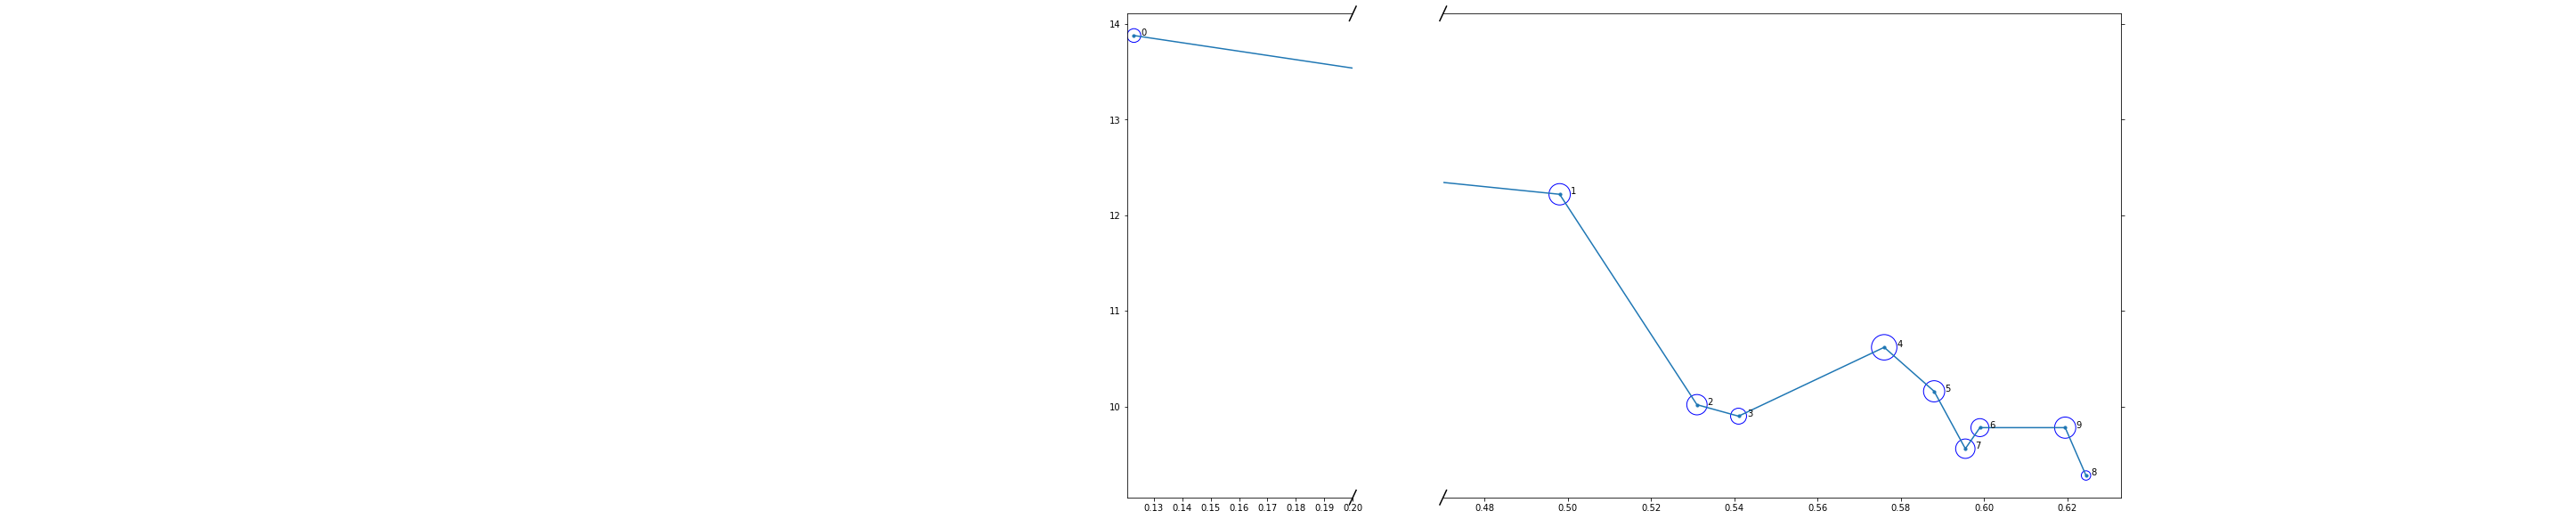

In [ ]:
to_sort = sorted(list(zip(accuracy, dist, variance, range(0, 11))), key=lambda x: x[0])
to_sort = list(zip(*to_sort))
var_rf_plot(to_sort[0], to_sort[1], to_sort[2], to_sort[3], [20,10], [0.18, 0.47])

###CM

In [ ]:
dist = [15.68, 12.84, 11.96, 12.66, 11.92, 12.48, 10.4, 12.28, 10.24, 10.18, 12.04]
variance = [0.5306122303009033,
 0.3902040719985962,
 0.5506122708320618,
 1.795918345451355,
 1.2506122589111328,
 0.37387755513191223,
 1.0567346811294556,
 1.1575510501861572,
 1.837142825126648,
 0.4310204088687897,
 0.5914285778999329]
accuracy = [0.07000000029802322,
 0.31150001287460327,
 0.5105000138282776,
 0.6380000114440918,
 0.6805000305175781,
 0.6820000410079956,
 0.706000030040741,
 0.7250000238418579,
 0.7070000171661377,
 0.7145000100135803,
 0.7245000600814819]

to_sort = sorted(list(zip(accuracy, dist, variance, range(0, 275, 25))), key=lambda x: x[0])
to_sort = list(zip(*to_sort))
var_rf_plot(to_sort[0], to_sort[1], to_sort[2], to_sort[3], [33,10])

### CC

In [ ]:
import numpy as np 
dist = [19.9, 20.34, 18.76, 17.44, 14.48, 16.16, 15.88, 15.36, 15.26, 14.48, 15.02]

variance = [1.3163264989852905, 1.7391836643218994, 2.431020498275757, 4.088163375854492, 
            2.9485714435577393, 2.4228570461273193, 2.7821094582093458, 2.8881633281707764, 3.6657142639160156, 2.9893877506256104, 2.8363265991210938]
                                
accuracy = [0.16550001502037048,
 0.49900001287460327,
 0.6045000553131104,
 0.6985000371932983,
 0.7105000615119934,
 0.7320000529289246,
 0.7380000346619412,
 0.7430000305175781,
 0.7480000257492065,
 0.7505000233650208,
 0.7560000419616699]

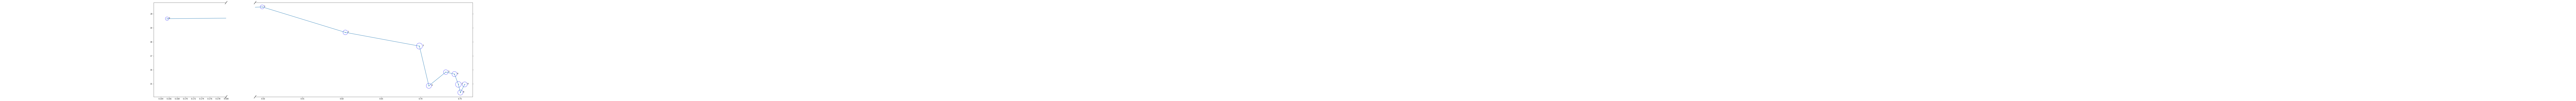

In [ ]:
to_sort = sorted(list(zip(accuracy, dist, variance, range(0, 11))), key=lambda x: x[0])
to_sort = list(zip(*to_sort))
var_rf_plot(to_sort[0], to_sort[1], to_sort[2], to_sort[3], [33,10], [0.18, 0.49])

### CB_pruned

In [ ]:
dist = [9.78, 11.12, 9.68, 10.86, 10.32, 10.0]
variance = [1.8893877267837524, 1.373061180114746, 1.1608163118362427, 0.36775511503219604, 0.5485714077949524, 0.0]
accuracy = [.6195, .6015, .4705, .4360, .3475, .1985]
epochs = [0, 0.5, 0.675, 0.75, 0.825, 0.9]

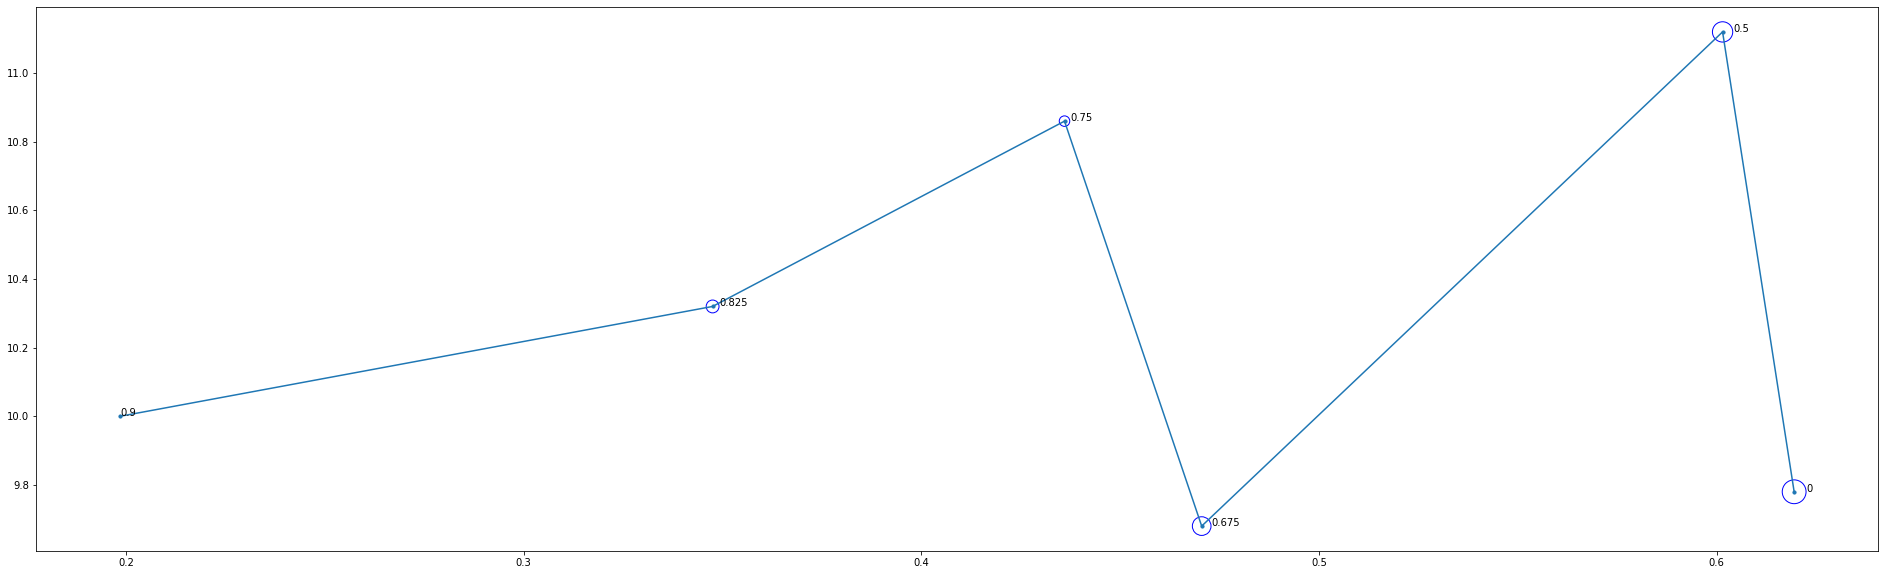

In [ ]:
to_sort = sorted(list(zip(accuracy, dist, variance, epochs)), key=lambda x: x[0])
to_sort = list(zip(*to_sort))
var_rf_plot(to_sort[0], to_sort[1], to_sort[2], to_sort[3], [33,10])

### CM_pruned

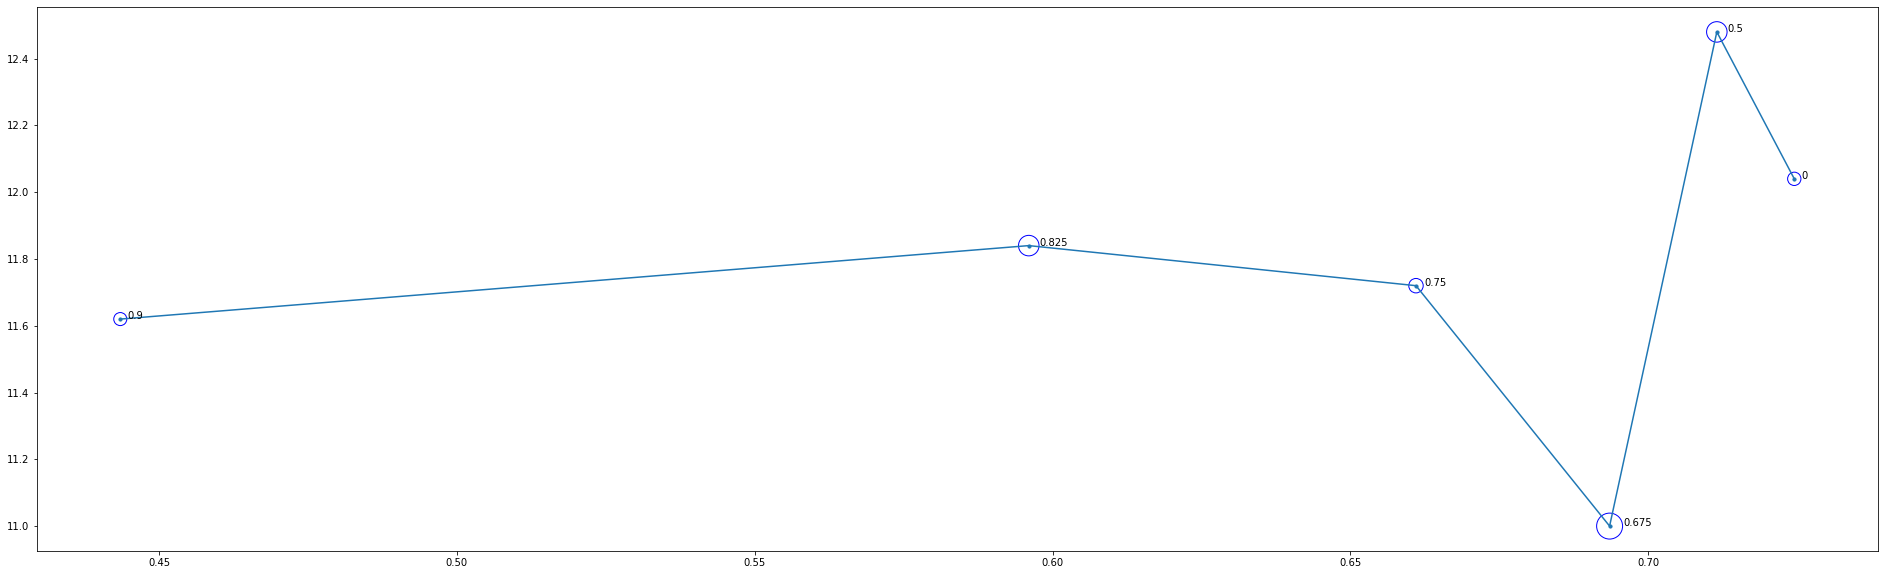

In [ ]:
dist = [12.04, 12.48, 11.0, 11.72, 11.84, 11.62]
variance = [0.5914285778999329, 1.3975510597229004, 2.2448978424072266, 0.69551020860672, 1.4024490118026733, 0.5669387578964233]
accuracy = [0.7245, 0.7115, .6935, 0.661, .596, .4435]
epochs = [0, 0.5, 0.675, 0.75, 0.825, 0.9]


to_sort = sorted(list(zip(accuracy, dist, variance, epochs)), key=lambda x: x[0])
to_sort = list(zip(*to_sort))
var_rf_plot(to_sort[0], to_sort[1], to_sort[2], to_sort[3], [33,10])

### CC_pruned

In [ ]:
dist = [14.9600, 13.66, 12.44, 13.64, 17.1, 15.14]
variance = [2.8363265991210938, 2.0657143592834473, 2.5779592990875244, 1.0922448635101318, 1.9693877696990967, 1.2248979806900024]
accuracy = [0.7560, .7585, .7375, .699, .626, .4075]
epochs = [0, 0.5, 0.675, 0.75, 0.825, 0.9]

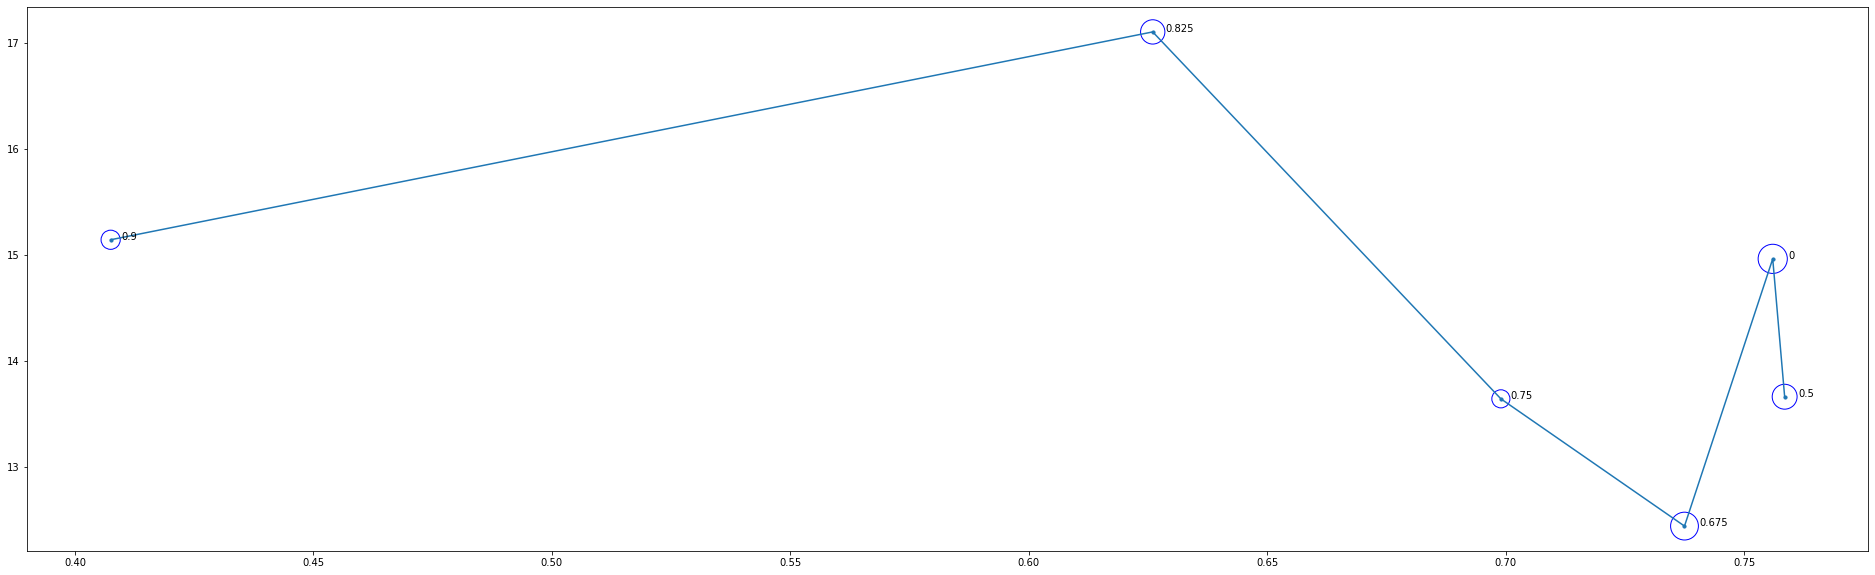

In [ ]:
to_sort = sorted(list(zip(accuracy, dist, variance, epochs)), key=lambda x: x[0])
to_sort = list(zip(*to_sort))
var_rf_plot(to_sort[0], to_sort[1], to_sort[2], to_sort[3], [33,10])

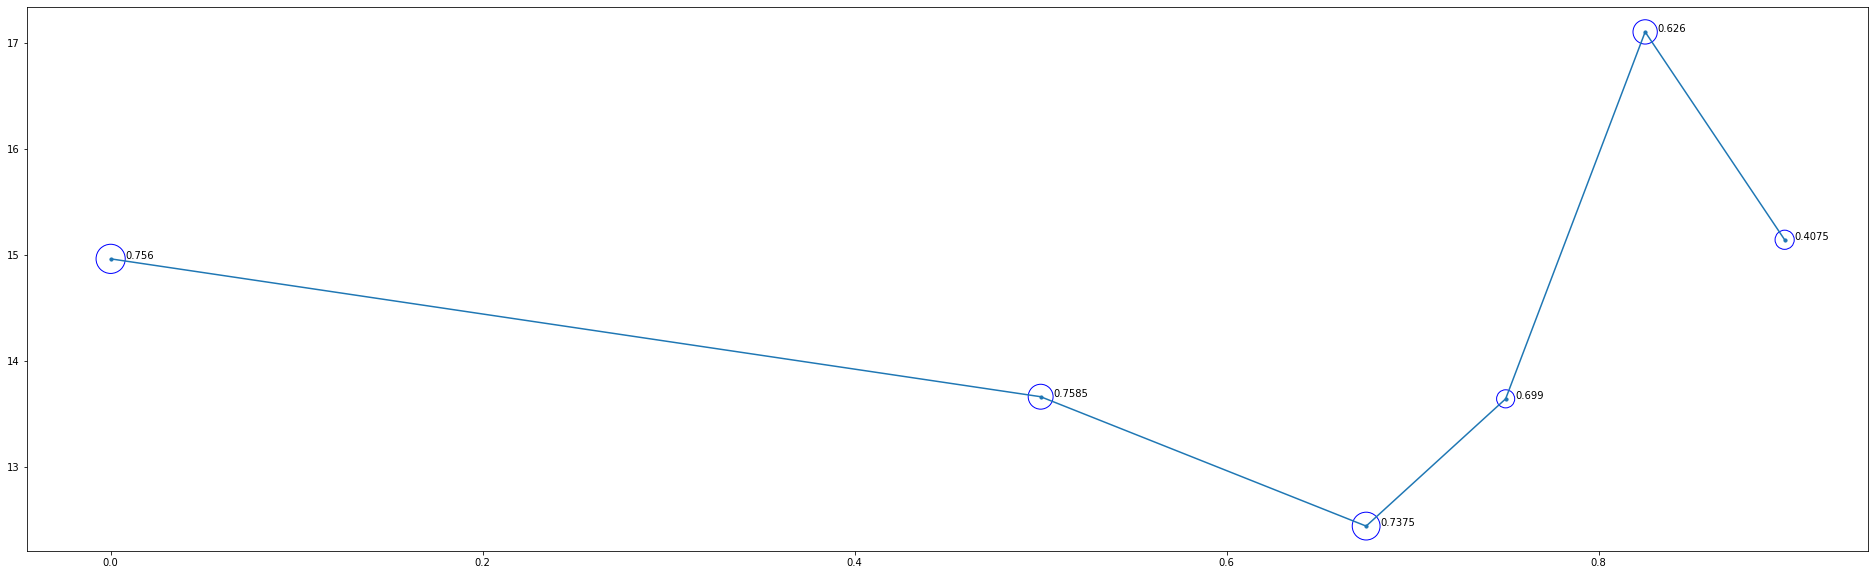

In [ ]:
dist = [14.9600, 13.66, 12.44, 13.64, 17.1, 15.14]
variance = [2.8363265991210938, 2.0657143592834473, 2.5779592990875244, 1.0922448635101318, 1.9693877696990967, 1.2248979806900024]
accuracy = [0.7560, .7585, .7375, .699, .626, .4075]
epochs = [0, 0.5, 0.675, 0.75, 0.825, 0.9]

to_sort = sorted(list(zip(epochs, dist, variance, accuracy)), key=lambda x: x[0])
to_sort = list(zip(*to_sort))
var_rf_plot(to_sort[0], to_sort[1], to_sort[2], to_sort[3], [33,10])

### CIFAR ALL

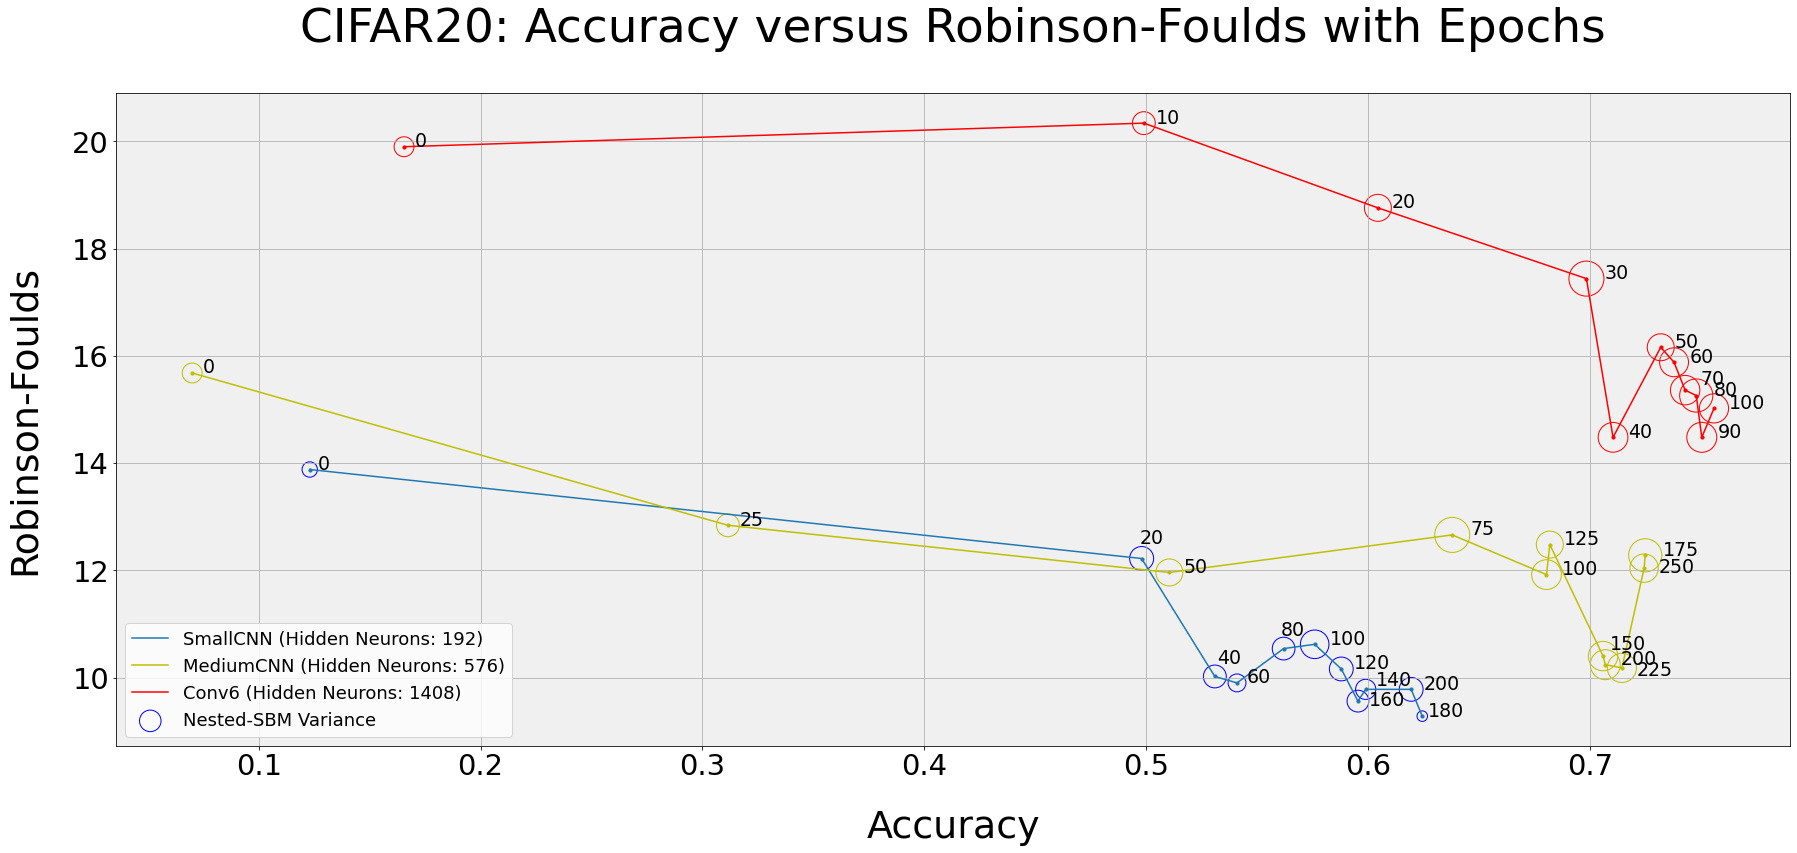

In [10]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (30,12)

dist = [13.88, 12.22, 10.02, 9.9, 10.54, 10.62, 10.16, 9.78, 9.56, 9.28, 9.78]
variance = [0.7873469591140747,
 1.9183673858642578,
 1.73714280128479,
 1.067755103111267,
 1.7212341090032834,
 2.7200000286102295,
 1.8893877267837524,
 1.3555102348327637,
 1.5791836977005005,
 0.3689796030521393,
 1.8893877267837524]

accuracy =[0.12300000339746475,
 0.49800002574920654,
 0.531000018119812,
 0.5410000085830688,
 0.5620000018951784,
 0.5760000348091125,
 0.5879999995231628,
 0.5990000367164612,
 0.5955000519752502,
 0.624500036239624,
 0.6195000410079956]

to_sort = sorted(list(zip(accuracy, dist, variance, range(0,220, 20))), key=lambda x: x[0])
to_sort = list(zip(*to_sort))

accuracy = to_sort[0]
dist = to_sort[1]
variance = to_sort[2]
epochs = to_sort[3]

fig, ax = plt.subplots()

s=[80*t for t in variance]

ax.scatter(accuracy, dist, s=[300*t for t in variance], facecolors='none', edgecolors='b')
ax.scatter(accuracy, dist, s=10)

ax.plot(accuracy,dist)

for i, txt in enumerate(epochs):
  if txt == 20:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]) - 15, 15),  textcoords="offset points", fontsize=19)
  elif txt == 40:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]) - 10, 13),  textcoords="offset points", fontsize=19)
  elif txt == 80:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]) - 15, 13),  textcoords="offset points", fontsize=19)  
  elif txt == 140:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]) , 4),  textcoords="offset points", fontsize=19)
  elif txt == 160:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]) , -4),  textcoords="offset points", fontsize=19)  
  else:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]), 0),  textcoords="offset points", fontsize=19)

dist = [15.68, 12.84, 11.96, 12.66, 11.92, 12.48, 10.4, 12.28, 10.24, 10.18, 12.04]
variance = [1.3163264989852905, 1.7391836643218994, 2.431020498275757, 4.088163375854492, 2.9485714435577393, 2.4228570461273193, 2.8881633281707764, 3.6657142639160156, 2.9893877506256104, 2.8363265991210938, 2.6823690532583493]
accuracy = [0.07000000029802322,
 0.31150001287460327,
 0.5105000138282776,
 0.6380000114440918,
 0.6805000305175781,
 0.6820000410079956,
 0.706000030040741,
 0.7250000238418579,
 0.7070000171661377,
 0.7145000100135803,
 0.7245000600814819]

to_sort = sorted(list(zip(accuracy, dist, variance, range(0, 275, 25))), key=lambda x: x[0])
to_sort = list(zip(*to_sort))

accuracy = to_sort[0]
dist = to_sort[1]
variance = to_sort[2]
epochs = to_sort[3]

s=[80*t for t in variance]

ax.scatter(accuracy, dist, s=[300*t for t in variance], facecolors='none', edgecolors='y')
ax.scatter(accuracy, dist, s=10, c = 'y')

ax.plot(accuracy,dist, c = 'y')

for i, txt in enumerate(epochs):
  if txt == 250:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]), -4),  textcoords="offset points", fontsize=19)
  elif txt == 225:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]), -8),  textcoords="offset points", fontsize=19)
  elif txt == 150:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]) - 8, 6),  textcoords="offset points", fontsize=19)
  else:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]), 0),  textcoords="offset points", fontsize=19)

dist = [19.9, 20.34, 18.76, 17.44, 14.48, 16.16, 15.88, 15.36, 15.26, 14.48, 15.02]

variance = [1.3163264989852905, 1.7391836643218994, 2.431020498275757, 4.088163375854492, 
            2.9485714435577393, 2.4228570461273193, 2.7821094582093458, 2.8881633281707764, 3.6657142639160156, 2.9893877506256104, 2.8363265991210938]
                                
accuracy = [0.16550001502037048,
 0.49900001287460327,
 0.6045000553131104,
 0.6985000371932983,
 0.7105000615119934,
 0.7320000529289246,
 0.7380000346619412,
 0.7430000305175781,
 0.7480000257492065,
 0.7505000233650208,
 0.7560000419616699]

to_sort = sorted(list(zip(accuracy, dist, variance, range(0, 110, 10))), key=lambda x: x[0])
to_sort = list(zip(*to_sort))

accuracy = to_sort[0]
dist = to_sort[1]
variance = to_sort[2]
epochs = to_sort[3]

s=[80*t for t in variance]

ax.scatter(accuracy, dist, s=[300*t for t in variance], facecolors='none', edgecolors='r')
ax.scatter(accuracy, dist, s=10, c = 'r')

ax.plot(accuracy,dist, c = 'r')

for i, txt in enumerate(epochs):
  if txt == 70:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]), 6),  textcoords="offset points", fontsize=19)
  else:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]), 0),  textcoords="offset points", fontsize=19)

plt.grid()
ax.set_facecolor('#F0F0F0')
ax.tick_params(axis='both', which='major', labelsize=29)
plt.legend(['SmallCNN (Hidden Neurons: 192)', 'MediumCNN (Hidden Neurons: 576)', 'Conv6 (Hidden Neurons: 1408)',  'Nested-SBM Variance'], prop={'size': 18}, loc='lower left')
ax.xaxis.labelpad = 29
ax.yaxis.labelpad = 29

plt.xlabel('Accuracy', fontsize=38)
plt.ylabel('Robinson-Foulds', fontsize=38)
plt.title('CIFAR20: Accuracy versus Robinson-Foulds with Epochs', fontsize=47, y=1.07)
plt.show()
#'-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

### CIFAR PRUNED ALL

In [ ]:
dist = [14.9600, 13.66, 12.44, 13.64, 17.1, 15.14]


In [ ]:
variance = [2.8363265991210938, 2.0657143592834473, 2.5779592990875244, 1.0922448635101318, 1.9693877696990967, 1.2248979806900024]
import math
[math.sqrt(x) for x in variance]

[1.6841397207836093,
 1.4372593222113563,
 1.6056024723098568,
 1.0451051925572525,
 1.4033487697999727,
 1.1067510924729203]

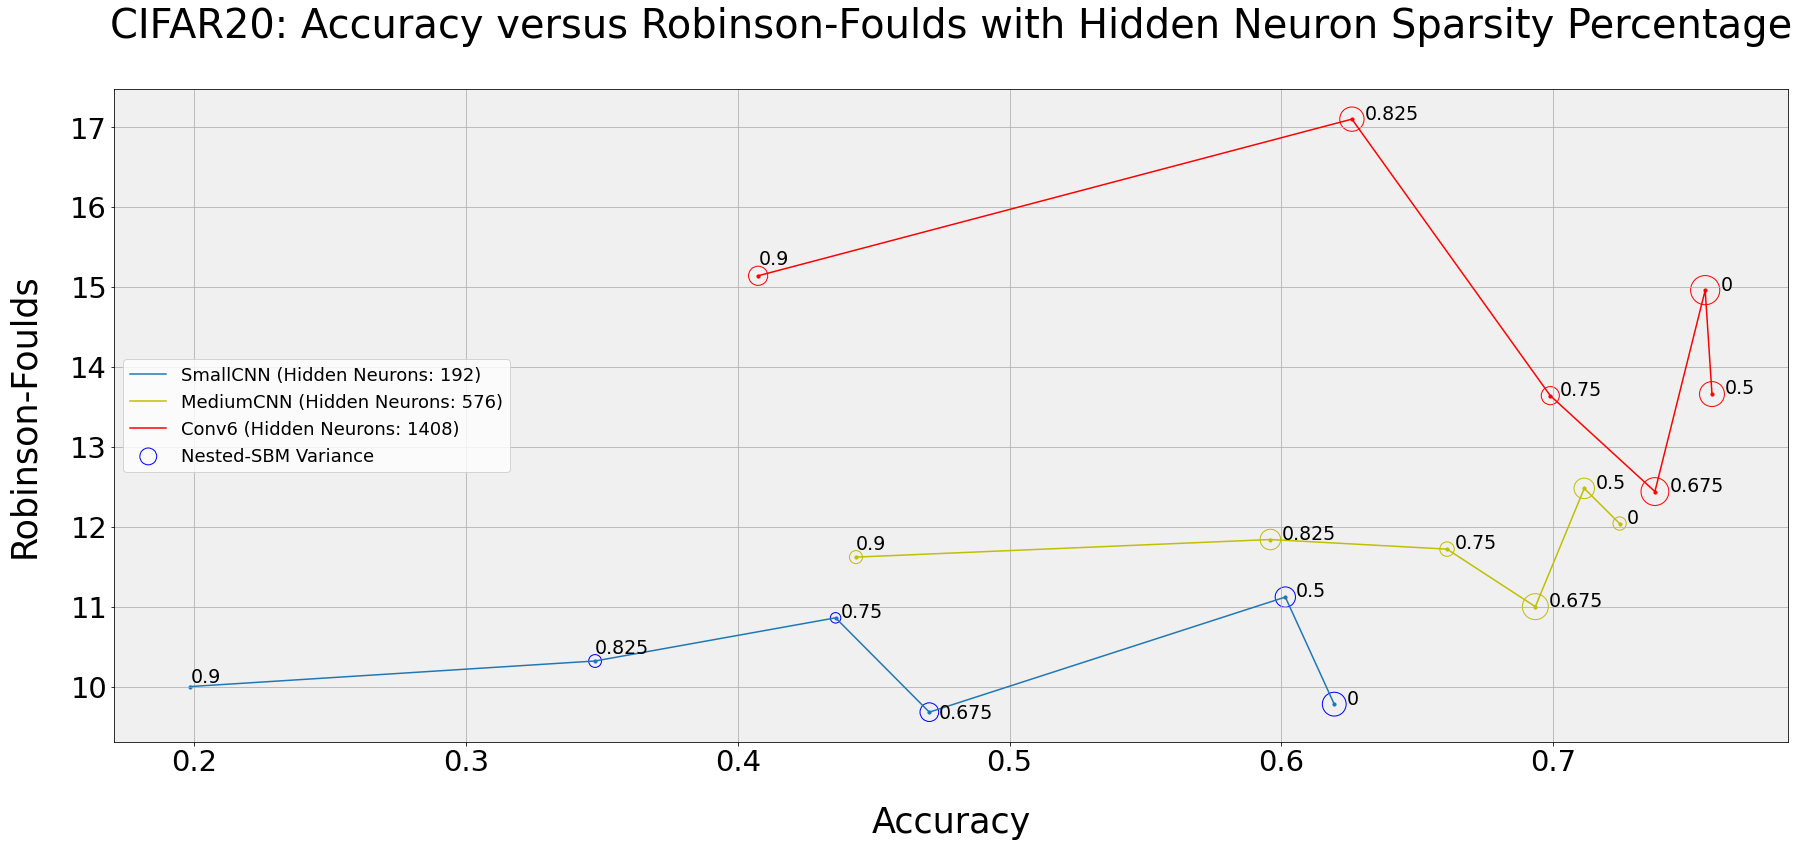

In [14]:
plt.rcParams["figure.figsize"] = (30,12)

#real-exponential
dist = [9.78, 11.12, 9.68, 10.86, 10.32, 10.0]
variance = [1.8893877267837524, 1.373061180114746, 1.1608163118362427, 0.36775511503219604, 0.5485714077949524, 0.0]
accuracy = [.6195, .6015, .4705, .4360, .3475, .1985]
epochs = [0, 0.5, 0.675, 0.75, 0.825, 0.9]

to_sort = sorted(list(zip(accuracy, dist, variance, epochs)), key=lambda x: x[0])
to_sort = list(zip(*to_sort))

accuracy = to_sort[0]
dist = to_sort[1]
variance = to_sort[2]
epochs = to_sort[3]

fig, ax = plt.subplots()

s=[80*t for t in variance]

ax.scatter(accuracy, dist, s=[300*t for t in variance], facecolors='none', edgecolors='b')
ax.scatter(accuracy, dist, s=10)

ax.plot(accuracy,dist)

for i, txt in enumerate(epochs):
  if txt == 0.9:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]), 4),  textcoords="offset points", fontsize=19)
  elif txt == 0.825:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]) - 7, 7),  textcoords="offset points", fontsize=19)
  elif txt == 0.675:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]), -6),  textcoords="offset points", fontsize=19)
  else:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]), 0),  textcoords="offset points", fontsize=19)


dist = [12.04, 12.48, 11.0, 11.72, 11.84, 11.62]
variance = [0.5914285778999329, 1.3975510597229004, 2.2448978424072266, 0.69551020860672, 1.4024490118026733, 0.5669387578964233]
accuracy = [0.7245, 0.7115, .6935, 0.661, .596, .4435]
epochs = [0, 0.5, 0.675, 0.75, 0.825, 0.9]

to_sort = sorted(list(zip(accuracy, dist, variance, epochs)), key=lambda x: x[0])
to_sort = list(zip(*to_sort))

accuracy = to_sort[0]
dist = to_sort[1]
variance = to_sort[2]
epochs = to_sort[3]

s=[80*t for t in variance]

ax.scatter(accuracy, dist, s=[300*t for t in variance], facecolors='none', edgecolors='y')
ax.scatter(accuracy, dist, s=10, c = 'y')

ax.plot(accuracy,dist, c = 'y')

for i, txt in enumerate(epochs):
  if txt == 0.9:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]) - 7, 7),  textcoords="offset points", fontsize=19)
  else:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]), 0),  textcoords="offset points", fontsize=19)

dist = [14.9600, 13.66, 12.44, 13.64, 17.1, 15.14]
variance = [2.8363265991210938, 2.0657143592834473, 2.5779592990875244, 1.0922448635101318, 1.9693877696990967, 1.2248979806900024]
accuracy = [0.7560000419616699, .7585, .7375, .699, .626, .4075]
epochs = [0, 0.5, 0.675, 0.75, 0.825, 0.9]

to_sort = sorted(list(zip(accuracy, dist, variance, epochs)), key=lambda x: x[0])
to_sort = list(zip(*to_sort))

accuracy = to_sort[0]
dist = to_sort[1]
variance = to_sort[2]
epochs = to_sort[3]

s=[80*t for t in variance]

ax.scatter(accuracy, dist, s=[300*t for t in variance], facecolors='none', edgecolors='r')
ax.scatter(accuracy, dist, s=10, c = 'r')

ax.plot(accuracy,dist, c = 'r')

for i, txt in enumerate(epochs):
  if txt == 0.9:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]) - 10, 11),  textcoords="offset points", fontsize=19)
  else:
    ax.annotate(txt, (accuracy[i], dist[i]), xytext=(accuracy[0] + np.sqrt(s[i]), 0),  textcoords="offset points", fontsize=19)

ax.tick_params(axis='both', which='major', labelsize=29)
plt.legend(['SmallCNN (Hidden Neurons: 192)', 'MediumCNN (Hidden Neurons: 576)', 'Conv6 (Hidden Neurons: 1408)',  'Nested-SBM Variance'], prop={'size': 18}, loc='center left')
plt.grid()
ax.set_facecolor('#F0F0F0')
ax.xaxis.labelpad = 29
ax.yaxis.labelpad = 29

plt.xlabel('Accuracy', fontsize=35)
plt.ylabel('Robinson-Foulds', fontsize=35)
plt.title('CIFAR20: Accuracy versus Robinson-Foulds with Hidden Neuron Sparsity Percentage', fontsize=40, y=1.07)
plt.show()
#'-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

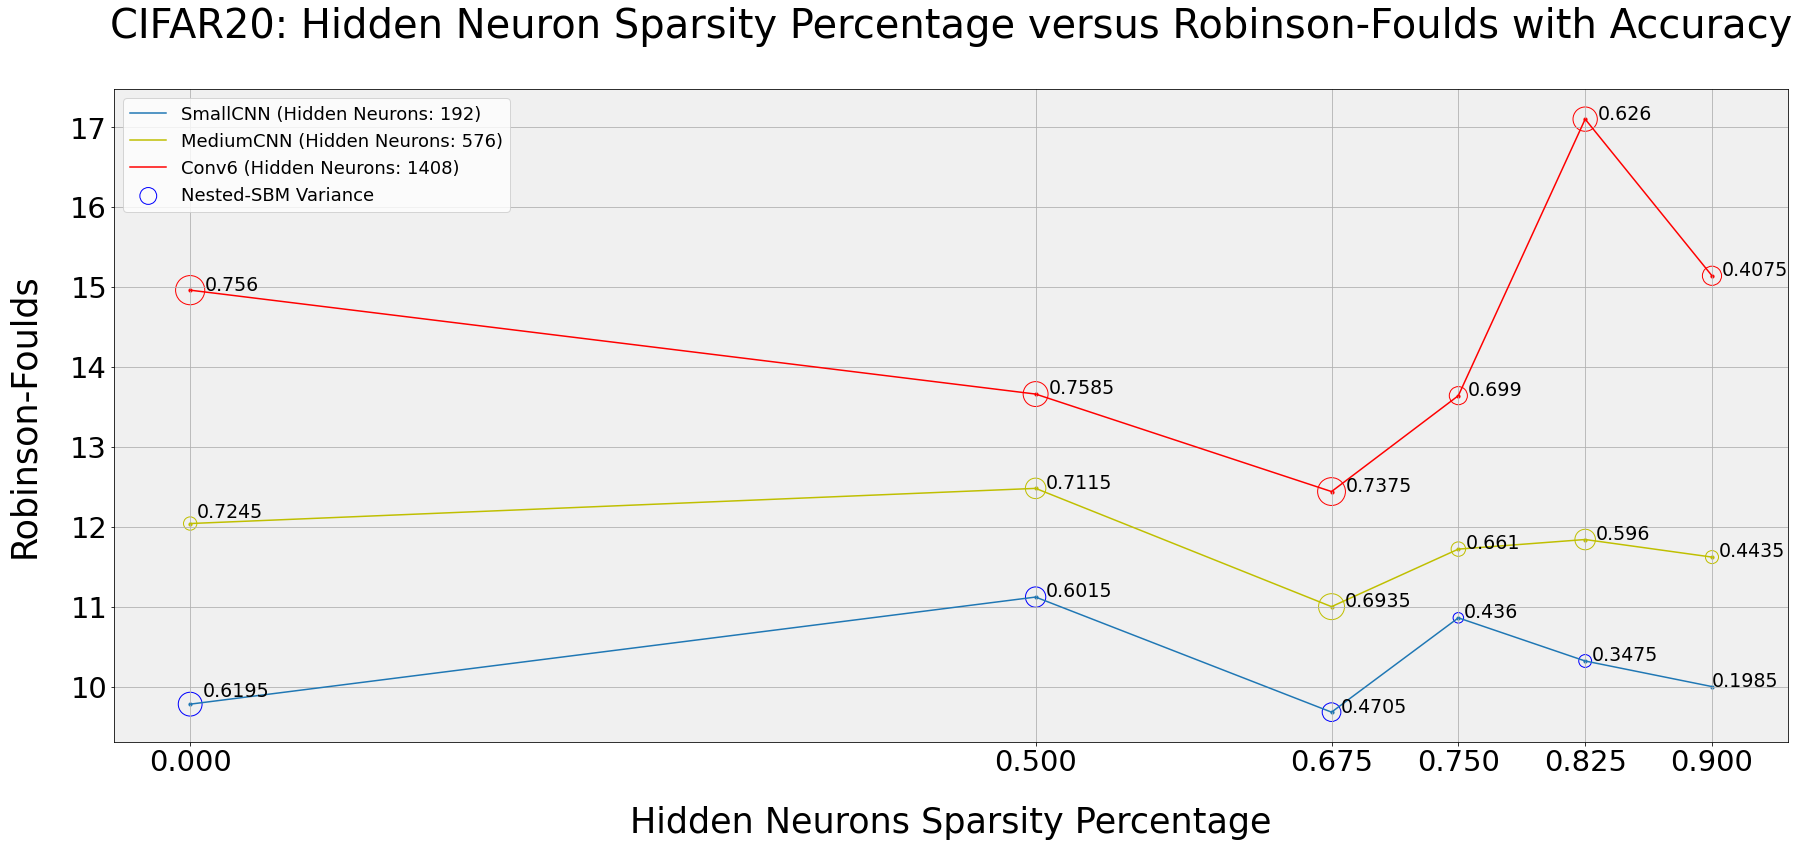

In [13]:
plt.rcParams["figure.figsize"] = (30,12)

dist = [9.78, 11.12, 9.68, 10.86, 10.32, 10.0]
variance = [1.8893877267837524, 1.373061180114746, 1.1608163118362427, 0.36775511503219604, 0.5485714077949524, 0.0]
accuracy = [.6195, .6015, .4705, .4360, .3475, .1985]
epochs = [0, 0.5, 0.675, 0.75, 0.825, 0.9]

to_sort = sorted(list(zip(epochs, dist, variance, accuracy)), key=lambda x: x[0])
to_sort = list(zip(*to_sort))

epochs = to_sort[0]
dist = to_sort[1]
variance = to_sort[2]
accuracy = to_sort[3]

fig, ax = plt.subplots()

s=[80*t for t in variance]

ax.scatter(epochs, dist, s=[300*t for t in variance], facecolors='none', edgecolors='b')
ax.scatter(epochs, dist, s=10)

ax.plot(epochs,dist)

for i, txt in enumerate(accuracy):
  if txt == 0.6195:
    ax.annotate(txt, (epochs[i], dist[i]), xytext=(epochs[0] + np.sqrt(s[i]), 8),  textcoords="offset points", fontsize=19)
  else:
    ax.annotate(txt, (epochs[i], dist[i]), xytext=(epochs[0] + np.sqrt(s[i]), 0),  textcoords="offset points", fontsize=19)


dist = [12.04, 12.48, 11.0, 11.72, 11.84, 11.62]
variance = [0.5914285778999329, 1.3975510597229004, 2.2448978424072266, 0.69551020860672, 1.4024490118026733, 0.5669387578964233]
accuracy = [0.7245, 0.7115, .6935, 0.661, .596, .4435]
epochs = [0, 0.5, 0.675, 0.75, 0.825, 0.9]

to_sort = sorted(list(zip(epochs, dist, variance, accuracy)), key=lambda x: x[0])
to_sort = list(zip(*to_sort))

epochs = to_sort[0]
dist = to_sort[1]
variance = to_sort[2]
accuracy = to_sort[3]

s=[80*t for t in variance]

ax.scatter(epochs, dist, s=[300*t for t in variance], facecolors='none', edgecolors='y')
ax.scatter(epochs, dist, s=10, c ='y')

ax.plot(epochs,dist, c= 'y')

for i, txt in enumerate(accuracy):
  if txt == 0.7245:
    ax.annotate(txt, (epochs[i], dist[i]), xytext=(epochs[0] + np.sqrt(s[i]), 6),  textcoords="offset points", fontsize=19)
  else:
    ax.annotate(txt, (epochs[i], dist[i]), xytext=(epochs[0] + np.sqrt(s[i]), 0),  textcoords="offset points", fontsize=19)


dist = [14.9600, 13.66, 12.44, 13.64, 17.1, 15.14]
variance = [2.8363265991210938, 2.0657143592834473, 2.5779592990875244, 1.0922448635101318, 1.9693877696990967, 1.2248979806900024]
accuracy = [0.756, .7585, .7375, .699, .626, .4075]
epochs = [0, 0.5, 0.675, 0.75, 0.825, 0.9]

to_sort = sorted(list(zip(epochs, dist, variance, accuracy)), key=lambda x: x[0])
to_sort = list(zip(*to_sort))

epochs = to_sort[0]
dist = to_sort[1]
variance = to_sort[2]
accuracy = to_sort[3]

s=[80*t for t in variance]

ax.scatter(epochs, dist, s=[300*t for t in variance], facecolors='none', edgecolors='r')
ax.scatter(epochs, dist, s=10, c = 'r')

ax.plot(epochs,dist, c = 'r')

for i, txt in enumerate(accuracy):
  ax.annotate(txt, (epochs[i], dist[i]), xytext=(epochs[0] + np.sqrt(s[i]), 0),  textcoords="offset points", fontsize=19)

plt.xticks(epochs)
ax.tick_params(axis='both', which='major', labelsize=29)
plt.legend(['SmallCNN (Hidden Neurons: 192)', 'MediumCNN (Hidden Neurons: 576)', 'Conv6 (Hidden Neurons: 1408)',  'Nested-SBM Variance'], prop={'size': 18}, loc='upper left')
plt.grid()
ax.set_facecolor('#F0F0F0')

ax.xaxis.labelpad = 29
ax.yaxis.labelpad = 29


plt.xlabel('Hidden Neurons Sparsity Percentage', fontsize=35)
plt.ylabel('Robinson-Foulds', fontsize=35)
plt.title('CIFAR20: Hidden Neuron Sparsity Percentage versus Robinson-Foulds with Accuracy', fontsize=40, y=1.07)
plt.show()
#'-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'